# Лабораторная работа №5
## Импорт библиотек

In [166]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.datasets import load_diabetes
from sklearn.decomposition import PCA
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score,
                             completeness_score, homogeneity_score,
                             silhouette_score, v_measure_score)
from sklearn.model_selection import ParameterGrid
from yellowbrick.cluster import KElbowVisualizer

warnings.filterwarnings('ignore')

## Функции

In [167]:
def plot_PCA(features: pd.DataFrame, labels: pd.Series, title: str, cluster_centers: np.ndarray = None) -> None:
    """
    Функция для визуализации данных с помощью метода главных компонент (PCA).

    :param features: Датафрейм с признаками для визуализации.
    :param labels: Серия с метками классов для каждого объекта.
    :param title: Заголовок графика.
    :param cluster_centers: Массив с координатами центров кластеров (необязательный параметр).
    """
    # Создаем объект PCA и преобразуем данные
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)
    x1, x2 = features_pca[:, 0], features_pca[:, 1]

    # Строим график
    scatter = plt.scatter(x1, x2, c=labels, cmap='viridis')

    # Если переданы координаты центров кластеров - отображаем их на графике
    if cluster_centers is not None:
        cluster_centers = pca.transform(cluster_centers)
        plt.scatter(
            cluster_centers[:, 0], cluster_centers[:, 1],
            c=np.arange(cluster_centers.shape[0]), cmap='viridis'
        )

        # # Добавляем подписи к центрам кластеров
        # for i, txt in enumerate(range(cluster_centers.shape[0])):
        #     plt.annotate(txt, (cluster_centers[i, 0], cluster_centers[i, 1]))

    # Улучшаем форматирование графика
    plt.xlabel("Информативный признак 1", fontsize=15)
    plt.ylabel("Информативный признак 2", fontsize=15)
    plt.title(title, fontsize=20)

    plt.show()


def elbow_val(features: pd.DataFrame, values_range: range) -> int:
    """
    Функция для определения оптимального количества кластеров с помощью метода "Локтя".

    :param features: Датафрейм с признаками для кластеризации.
    :param values_range: Диапазон значений для количества кластеров.
    :return: Оптимальное количество кластеров.
    """
    # Создаем объект KElbowVisualizer и строим график "Локтя"
    k_elbow = KElbowVisualizer(KMeans(), k=values_range, title="Метод Локтя")
    k_elbow.fit(features)
    k_elbow.show()

    # Возвращаем оптимальное количество кластеров
    return k_elbow.elbow_value_


def cl_scores(features: pd.DataFrame, true_labels: pd.Series, predicted_labels: pd.Series) -> pd.Series:
    """
    Функция для расчета метрик качества кластеризации.

    :param features: Датафрейм с признаками для кластеризации.
    :param true_labels: Серия с истинными метками классов для каждого объекта.
    :param predicted_labels: Серия с предсказанными метками классов для каждого объекта.
    :return: Серия с метриками качества кластеризации.
    """

    # Рассчитываем метрики качества кластеризации
    scores = {
        'Adjusted Rand Index': adjusted_rand_score(true_labels, predicted_labels),
        'Adjusted Mutual Information': adjusted_mutual_info_score(true_labels, predicted_labels),
        'Homogeneity Score': homogeneity_score(true_labels, predicted_labels),
        'Completeness Score': completeness_score(true_labels, predicted_labels),
        'V-Measure Score': v_measure_score(true_labels, predicted_labels),
        'Silhouette Score': silhouette_score(features, predicted_labels),
    }

    scores_series = pd.Series(scores)

    # Строим столбчатую диаграмму для каждой метрики качества
    scores_series.plot(kind='bar')
    plt.title('Метрики качества кластеризации')
    plt.show()

    return pd.Series(scores)

## Обработка данных

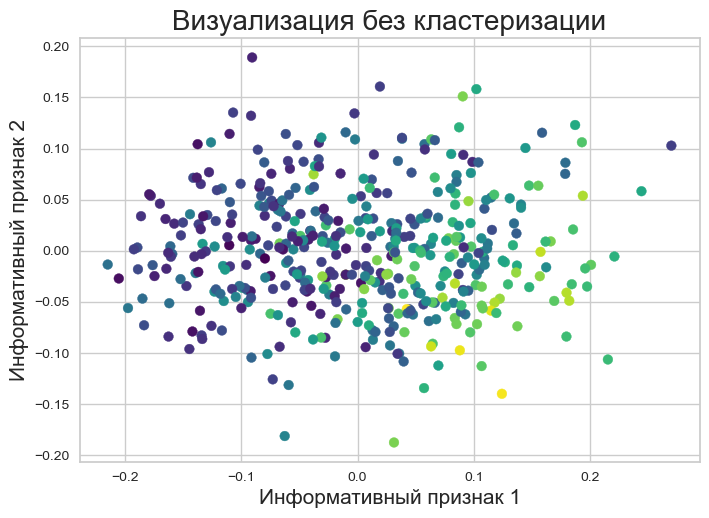

In [168]:
# Загружаем данные о диабете
data = load_diabetes()
df_diabetes = pd.DataFrame(data.data, columns=data.feature_names)

# Разделяем данные на признаки и метки классов (в данном случае - прогресс заболевания через год после начала лечения)
features = df_diabetes
labels = data.target

# Визуализируем данные без кластеризации
plot_PCA(features,
         labels, "Визуализация без кластеризации")

## KMeans

## Определяем количество кластеров как количество уникальных меток классов

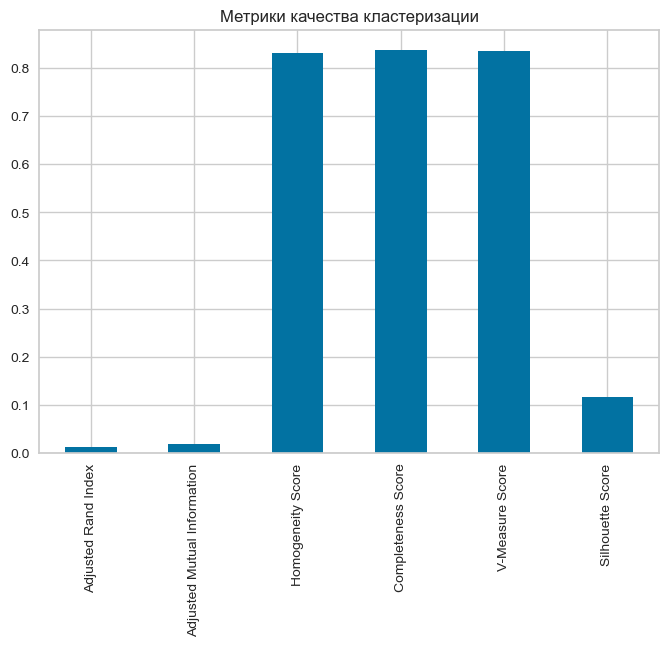

Adjusted Rand Index            0.013525
Adjusted Mutual Information    0.019136
Homogeneity Score              0.830272
Completeness Score             0.837565
V-Measure Score                0.833903
Silhouette Score               0.115582
dtype: float64

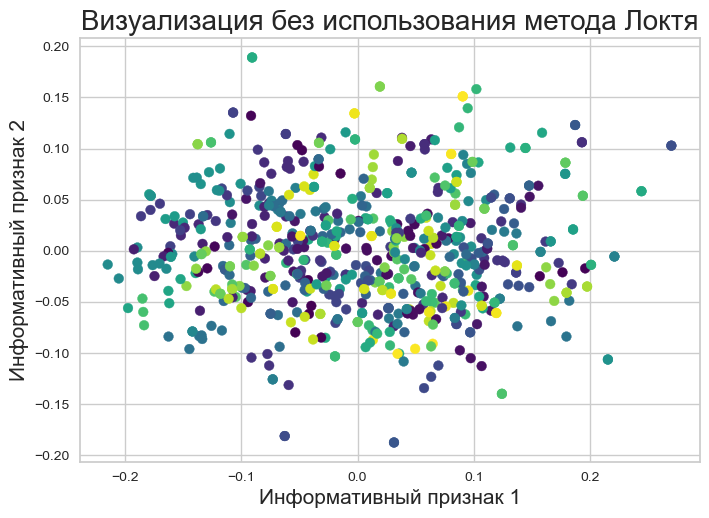

In [169]:
top_clusters_num = np.unique(labels if isinstance(labels, np.ndarray) else labels.values).size

# Создаем и обучаем модель KMeans
kmeans = KMeans(n_clusters=top_clusters_num)
kmeans.fit(features)

# Получаем предсказанные метки классов
predicted_labels = kmeans.predict(features)

# Рассчитываем и выводим метрики качества кластеризации
display(cl_scores(features, labels, kmeans.labels_))

# Визуализируем результаты кластеризации KMeans без использования метода "Локтя"
plot_PCA(features, predicted_labels, "Визуализация без использования метода Локтя", kmeans.cluster_centers_)

## Определяем оптимальное количество кластеров с помощью метода "Локтя"

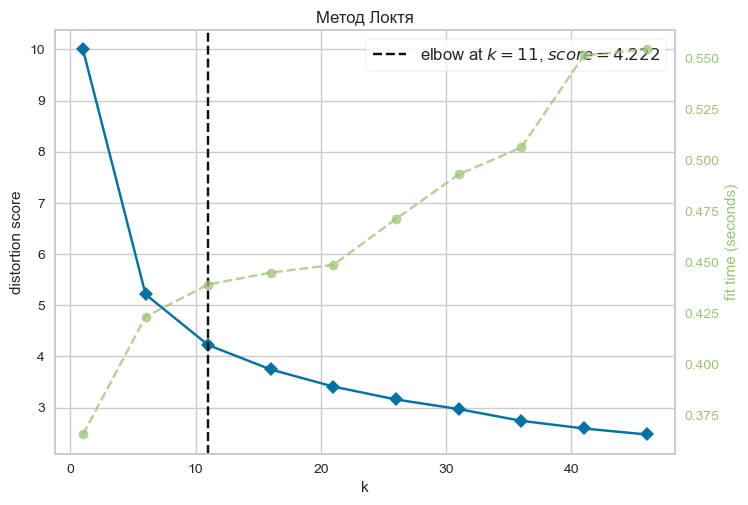

Оптимальное количество кластеров: 11


In [170]:
k_elbow = KElbowVisualizer(KMeans(), k=range(1, 50, 5), title="Метод Локтя")
k_elbow.fit(features)
k_elbow.show()
top_clusters_num = k_elbow.elbow_value_

# Создаем и обучаем модель KMeans с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=top_clusters_num)
kmeans.fit(features)

# Скрываем легенду
k_elbow.ax.get_legend().remove()

print(f'Оптимальное количество кластеров: {top_clusters_num}')

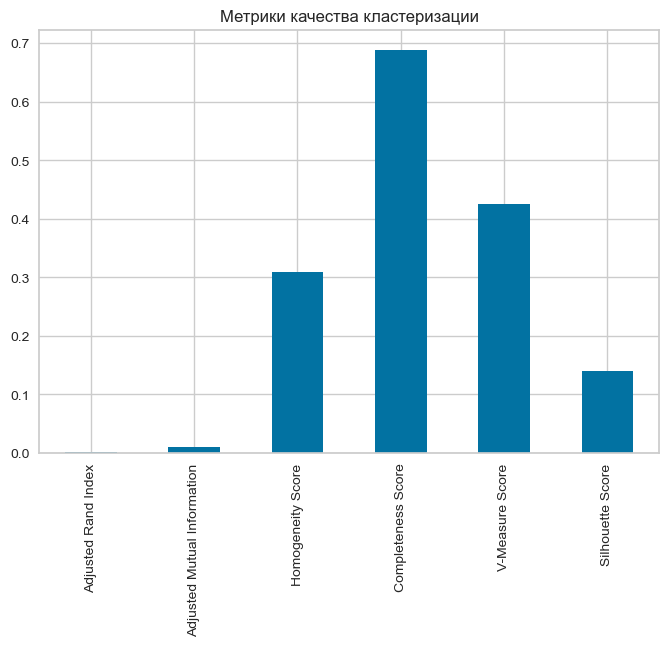

Adjusted Rand Index            0.002076
Adjusted Mutual Information    0.010983
Homogeneity Score              0.308371
Completeness Score             0.688769
V-Measure Score                0.426011
Silhouette Score               0.140765
dtype: float64

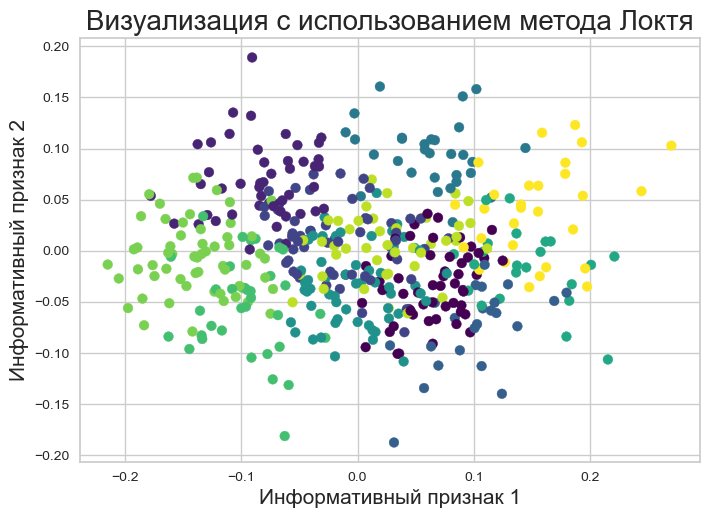

In [171]:
# Получаем предсказанные метки классов
predicted_labels = kmeans.predict(features)

# Рассчитываем и выводим метрики качества кластеризации
display(cl_scores(features, labels, kmeans.labels_))
# Визуализируем результаты кластеризации KMeans c использованием метода "Локтя"
plot_PCA(features, predicted_labels, "Визуализация с использованием метода Локтя", kmeans.cluster_centers_)

## Поиск лучшей модели AffinityPropagation

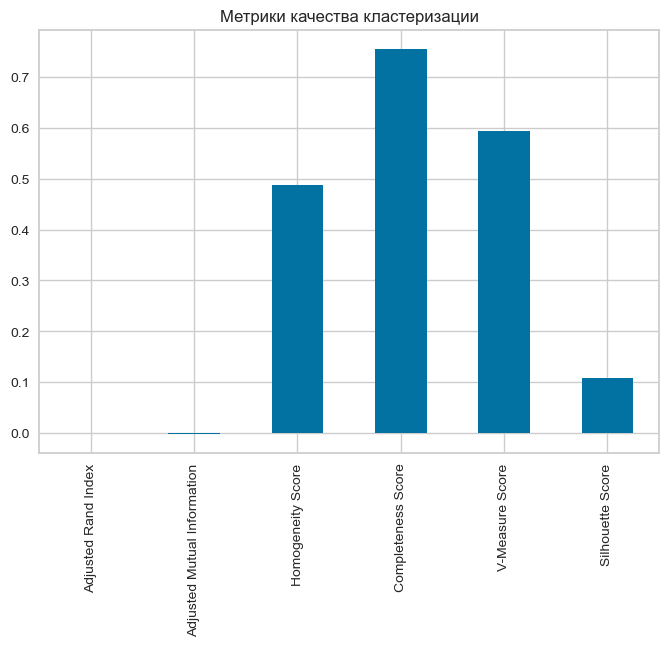

Adjusted Rand Index           -0.000151
Adjusted Mutual Information   -0.001358
Homogeneity Score              0.488405
Completeness Score             0.755111
V-Measure Score                0.593157
Silhouette Score               0.108932
dtype: float64

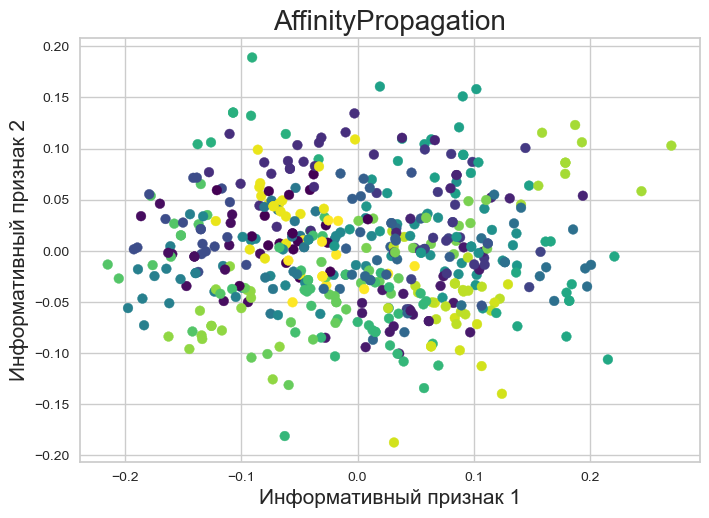

In [172]:
# Задаем сетку параметров для поиска лучшей модели AffinityPropagation
af_grid = {
    'damping': np.arange(0.5, 1.0, 0.1),
    'max_iter': range(50, 500, 50),
}

fitted = []
for params in ParameterGrid(af_grid):
    af_prop = AffinityPropagation(**params).fit(features)
fitted.append((af_prop, silhouette_score(features,
                                         af_prop.labels_)))

af_prop = max(fitted, key=lambda model: model[1])[0]
top_clusters_num = len(af_prop.cluster_centers_indices_)
display(cl_scores(features, labels, af_prop.labels_))
plot_PCA(features, af_prop.labels_, "AffinityPropagation", af_prop.cluster_centers_)